# 0-60mph with CMIP6 datasets in the clouuuuuuud

## Learning goals

## Caveats
1. This notebook is exectuable locally
1. This notebook dooes not demonstrate the use of dask for parallelism.
1. Pangeo gallery is down for now due to cryptomining abuse.
1. If you want to work more seriously on the data sign up to pangeo deployments.

## Reading data

The data are stored in the cloud.  We  do not interact with the "files" (or "assets") directly. Instead we access them through a catalog that contains all the information needed to read the data.

Here we use the catalog functionality provided by intake.

In [2]:
import intake
import numpy as np
import matplotlib.pyplot as plt
from cmip6_preprocessing.preprocessing import combined_preprocessing

url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
# url = "https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,701
grid_label,10
zstore,515510
dcpp_init_year,60


**TODO: add some description of the catalog repr**

**TODO: is there a link that describes this vocabulary**

One rarely uses the full archive, and usually we want to search for a subset of data. Subsets are defined by 'facets' (shown above). 

So for instance, if we only want to look at the historical forcing experiment, we can search for it like this:

In [2]:
cat = col.search(experiment_id = 'historical')
cat

,unique
activity_id,1
institution_id,31
source_id,65
experiment_id,1
member_id,201
table_id,34
variable_id,648
grid_label,9
zstore,86693
dcpp_init_year,0


Thats still a lot of data, so lets search for several facets at the same time to get this down to a bunch of datasets we can use in the tutorial.

Lets pick the ocean salinity `so` variable for monthly output (`Omon`) and the native grid (`gn`). You can explore other variables [here]().



In [3]:
cat = col.search(
    experiment_id = 'historical',
    variable_id='so',
    table_id='Omon',
    grid_label='gn',
)
cat

,unique
activity_id,1
institution_id,27
source_id,52
experiment_id,1
member_id,182
table_id,1
variable_id,1
grid_label,1
zstore,547
dcpp_init_year,0


Lets see which models are available in this subset:

In [4]:
np.sort(cat.df['source_id'].unique())

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR',
       'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2',
       'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM',
       'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1',
       'CNRM-ESM2-1', 'CanESM5', 'CanESM5-CanOE', 'EC-Earth3',
       'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-Veg',
       'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0',
       'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC',
       'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'ICON-ESM-LR',
       'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR', 'IPSL-CM6A-LR-INCA',
       'MCM-UA-1-0', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM-1-2-HAM',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorCPM1',
       'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'TaiESM1',
       'UKESM1-0-LL'], dtype=object)

Thats a lot. We will chose only three models here as an example, but feel free to plug in anyone of the ones shown above!

Provide model name as `source_id`

In [5]:
cat = col.search(
    experiment_id = 'historical',
    variable_id='so',
    table_id='Omon',
    grid_label='gn',
    source_id=['MPI-ESM1-2-HR', 'CanESM5-CanOE', 'GFDL-ESM4']
)
cat

,unique
activity_id,1
institution_id,3
source_id,3
experiment_id,1
member_id,13
table_id,1
variable_id,1
grid_label,1
zstore,13
dcpp_init_year,0


Ok time to load the datasets into a dictionary. Note that this is only 'lazily' loading the data, which means we only access the metadata, and the full output is only loaded once we perform a computation!

`datasets_dict` is a dictionary mapping a long unique namelike`'CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1.Omon.so ...` to an xarray Dataset that represent the model output.

Note that this step will be a little slow if executed on your laptop; it is a lot faster in the cloud

In [6]:
datasets_dict = cat.to_dataset_dict(
    zarr_kwargs={'use_cftime':True,'consolidated':True},
    aggregate=False,
    preprocess=combined_preprocessing
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [7]:
datasets_dict

{'CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1.Omon.so.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r1i1p2f1/Omon/so/gn/v20190429/.nan.20190429': <xarray.Dataset>
 Dimensions:        (x: 360, y: 291, lev: 45, bnds: 2, time: 1980, vertex: 4)
 Coordinates: (12/14)
   * x              (x) int32 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
   * y              (y) int32 0 1 2 3 4 5 6 7 ... 283 284 285 286 287 288 289 290
     lat            (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
   * lev            (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
     lev_bounds     (lev, bnds) float64 dask.array<chunksize=(45, 2), meta=np.ndarray>
     lon            (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
     ...             ...
     lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
     lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
   * bnds   

Here is the first dataset for inspection

In [10]:
list(datasets_dict.values())[0]

<xarray.Dataset>
Dimensions:        (x: 360, y: 291, lev: 45, bnds: 2, time: 1980, vertex: 4)
Coordinates: (12/14)
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * y              (y) int32 0 1 2 3 4 5 6 7 ... 283 284 285 286 287 288 289 290
    lat            (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * lev            (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(45, 2), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    ...             ...
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
  * bnds           (bnds) int64 0 1
  * vertex         (vertex) int64 0 1 2 3
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 291, 360), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 291, 360), meta=np.ndarray>
Data variables:
    so             (time, lev, y, x) float32 dask.array<chunksize=(7, 45, 291, 360), meta=np.ndarray>
Attributes: (12/58)
    CCCma_model_hash:            932b659de600c6a0e94f619abaf9cc79eabcd337
    CCCma_parent_runid:          canoecpl-007
    CCCma_pycmor_hash:           3ecdc18eb7c1f7fbce0346850f41adf815d9fb66
    CCCma_runid:                 c2-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variant_label:               r1i1p2f1
    version:                     v20190429
    netcdf_tracking_ids:         hdl:21.14100/3e4e67a7-235c-4c19-bcf3-5b66b0e...
    version_id:                  v20190429
    intake_esm_varname:          None
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1...

Now lets do something really simple: Plot the surface salinity at the first timestep

/Users/dcherian/mambaforge/envs/tutorial_osm22_cmip6/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/Users/dcherian/mambaforge/envs/tutorial_osm22_cmip6/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks'

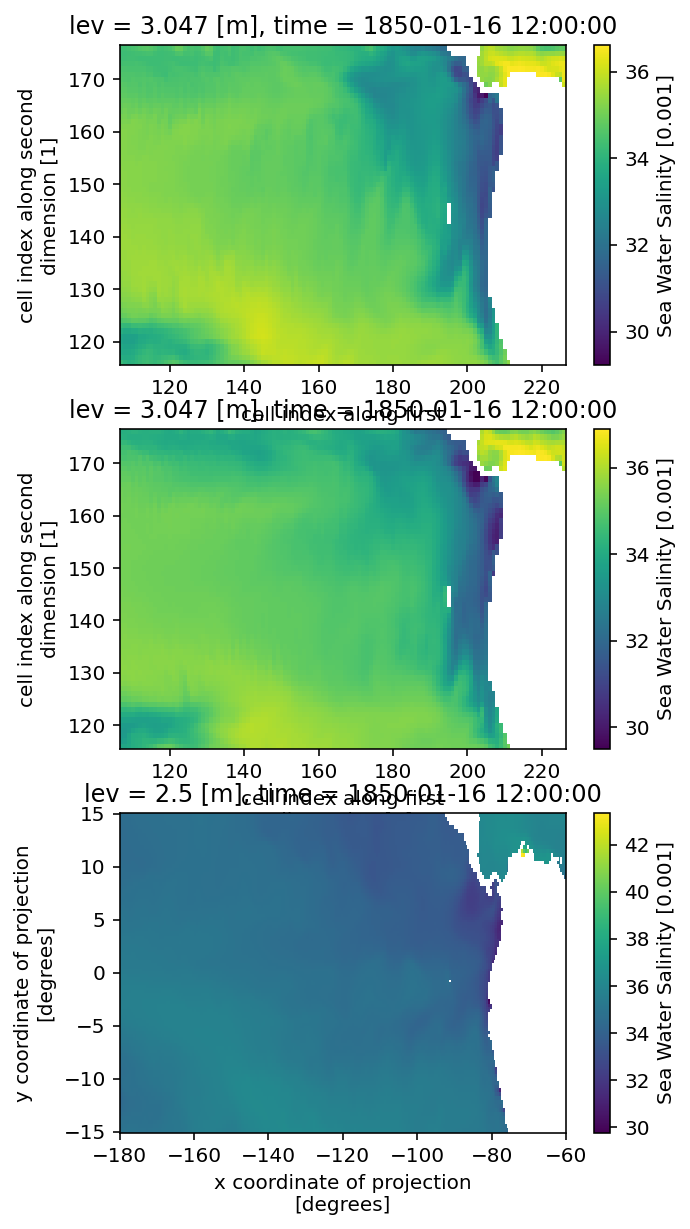

In [11]:
import numpy as np

fig, axarr = plt.subplots(nrows=3, figsize=[5, 10])
for ds, ax in zip(datasets_dict.values(), axarr.flat):
    masked_ds = ds.where(
        (ds.lon > 180) & (ds.lon < 300) & (ds.lat < 15) & (ds.lat > -15), drop=True
    )
    masked_ds.isel(time=0, lev=0).so.plot(ax=ax)

## Some simple examples
- select ocean basin/box region
- plot a timeseries

### Bonus xgcm
- Tracer on density surface